In [1]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from numba import jit,cuda
import tensorflow as tf
from time import time
import pickle as pkl
from keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from skimage.io import imsave


In [ ]:
%%cmd
pip install wandb
pip install scikit-image
pip install skimage
pip install numba
pip install keras-unet

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
trainImageColorful = list(map(lambda x : "data/train/"+x ,os.listdir("data/train/")[0:6000]))
testImageColorful = list(map(lambda x : "data/test/"+x ,os.listdir("data/test/")))


In [4]:
len(trainImageColorful)

6000

In [5]:
def preprocess_image_to_gray_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,0]
    img = img.reshape(400, 400, 1)
    
    return img

def preprocess_image_to_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,1:]
    img /= 128
    img = img.reshape(400, 400, 2)

    return img



In [6]:
trainImageColorful[0]

'data/train/1000268201_693b08cb0e.jpg'

In [ ]:
start = time()

testX={}
testY={}


for ix,img in enumerate(testImageColorful):
    

   
    testX[img.split("/")[2][:-4]] = preprocess_image_to_gray_lab(img)
    testY[img.split("/")[2][:-4]] = preprocess_image_to_lab(img)
 

    if ix%100==0:
        print("Process test image - "+str(ix))

print("Time taken in seconds = ", time()-start)

In [ ]:
with open("pickles/process_test_imagesX.pkl","wb") as process_pickle:
    pkl.dump(testX,process_pickle)
with open("pickles/process_test_imagesY.pkl","wb") as process_pickle:
    pkl.dump(testY,process_pickle)

 

In [ ]:
with open("pickles/process_test_imagesX.pkl","rb") as f:
    testX = pkl.load(f)
with open("pickles/process_test_imagesY.pkl","rb") as f:
    testY = pkl.load(f)

In [7]:
start = time()

trainX={}
trainY={}


for ix, img in enumerate(trainImageColorful):
    
    img=trainImageColorful[ix]
   
    
    trainX[img.split("/")[2][:-4]] = preprocess_image_to_gray_lab(img)
    trainY[img.split("/")[2][:-4]] = preprocess_image_to_lab(img)
   
 

    if ix%100==0:
        print("Process image - "+str(ix))

print("Time taken in seconds = ", time()-start)

Encoding image - 0
Encoding image - 100
Encoding image - 200
Encoding image - 300
Encoding image - 400
Encoding image - 500
Encoding image - 600
Encoding image - 700
Encoding image - 800
Encoding image - 900
Encoding image - 1000
Encoding image - 1100
Encoding image - 1200
Encoding image - 1300
Encoding image - 1400
Encoding image - 1500
Encoding image - 1600
Encoding image - 1700
Encoding image - 1800
Encoding image - 1900
Encoding image - 2000
Encoding image - 2100
Encoding image - 2200
Encoding image - 2300
Encoding image - 2400
Encoding image - 2500
Encoding image - 2600
Encoding image - 2700
Encoding image - 2800
Encoding image - 2900
Encoding image - 3000
Encoding image - 3100
Encoding image - 3200
Encoding image - 3300
Encoding image - 3400
Encoding image - 3500
Encoding image - 3600
Encoding image - 3700
Encoding image - 3800
Encoding image - 3900
Encoding image - 4000
Encoding image - 4100
Encoding image - 4200
Encoding image - 4300
Encoding image - 4400
Encoding image - 4500


In [8]:
with open("pickles/process_train_imagesX.pkl","wb") as process_pickle:
    pkl.dump(trainX,process_pickle)
with open("pickles/process_train_imagesY.pkl","wb") as process_pickle:
    pkl.dump(trainY,process_pickle)

In [ ]:
trainX={}
trainY={}

with open("pickles/process_train_imagesX.pkl","rb") as f:
    trainX = pkl.load(f)

with open("pickles/process_train_imagesY.pkl","rb") as f:
    trainY = pkl.load(f)

In [9]:

def data_generator(trainX,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in trainImageColorful:
            n +=1

            photo = trainX[key.split("/")[2][:-4]]

            photoColor = trainY[key.split("/")[2][:-4]]

          
          
                
            X.append(photo)
                   
            y.append(photoColor)
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0



In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#import wandb 
#wandb.init()

In [11]:
model = Sequential()
model.add(InputLayer(input_shape=(400, 400, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same' , strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same' , strides=2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same' ))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))



In [12]:
model.compile(optimizer='rmsprop',loss='mse' ,metrics=[
        "accuracy"
    ])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 128)     73856     
                                                        

In [13]:
epochs = 50
number_pics_per_bath = 10
steps = len(trainImageColorful)//number_pics_per_bath

In [14]:
@jit(target_backend='cuda') 
def runModel():
    for i in range(epochs):
     
        generator = data_generator(trainX=trainX,num_photos_per_batch=number_pics_per_bath)
 
        model.fit(generator,epochs=10,steps_per_epoch=steps,verbose=1)
        model.save("./model_weights/model_"+str(i)+".h5")
        print("./model_weights/model_"+str(i)+".h5 kaydedildi")

In [ ]:
runModel()

In [16]:
from keras.models import Model,load_model
model = load_model("model_weights\model_23.h5")

In [53]:
def show_images(i,coloring):
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
  
    normal = load_img(i,color_mode="grayscale",target_size=(400,400))
    plt.imshow(normal, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title("Gray image")
    

    fig.add_subplot(rows, columns, 2)
    
  
    plt.imshow(coloring)
    plt.axis('off')
    plt.title("AI Colorizing")

def mergeOutput(x,output):
    output *= 128
  
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = x[0][:,:,0]
    cur[:,:,1:] = output[0]
    return cur

1/1 [==============================] - 0s 29ms/step


c:\Users\hosma\anaconda3\envs\machineLearning\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 25ms/step


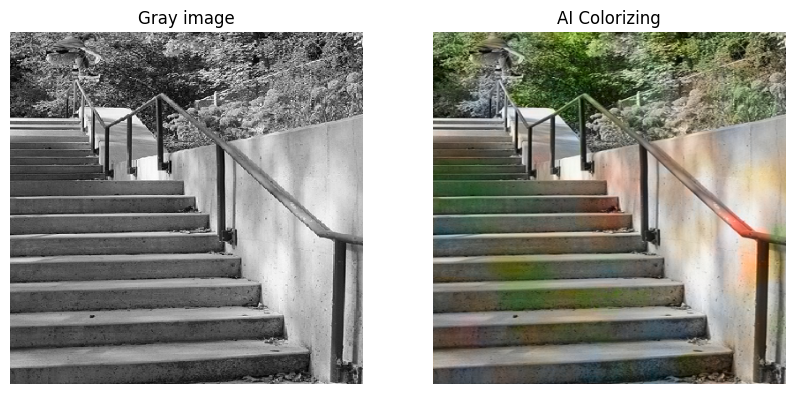

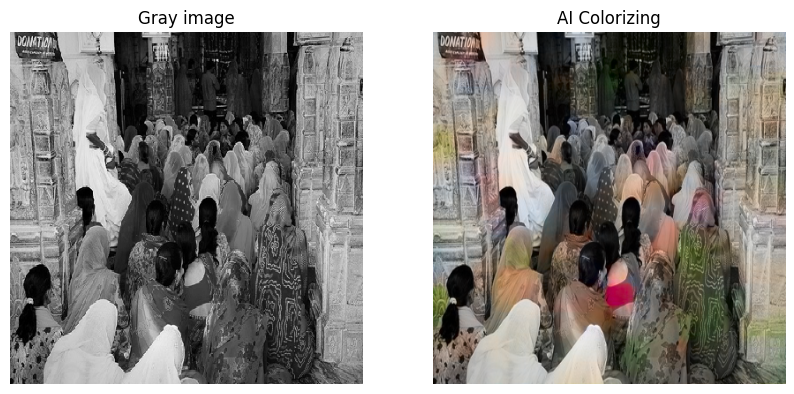

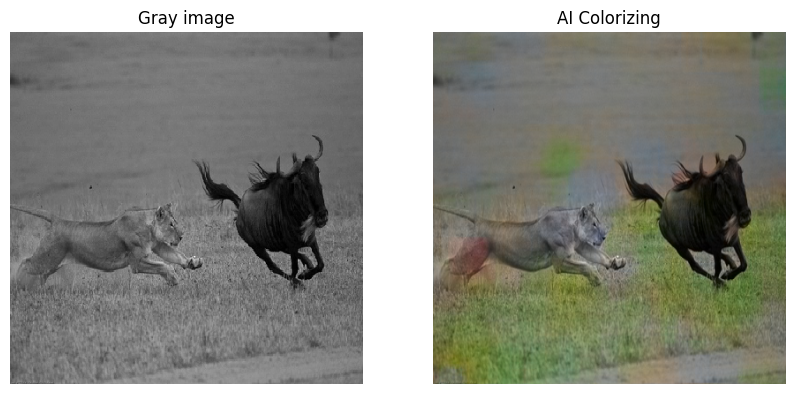

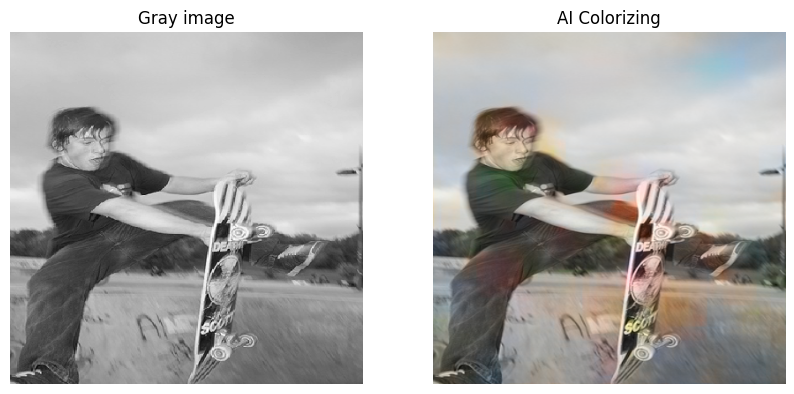

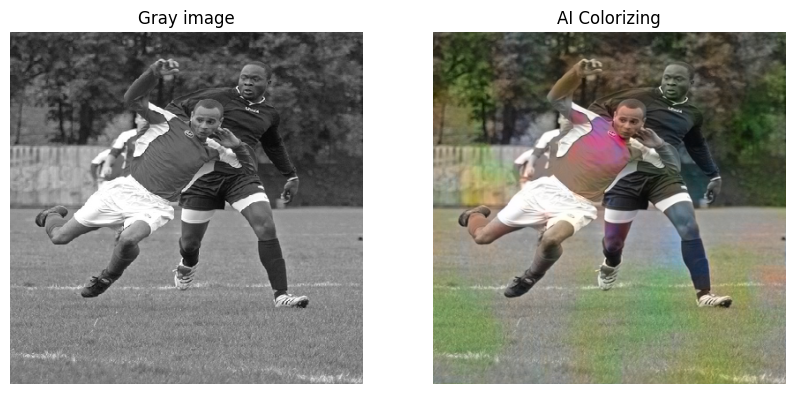

In [73]:
for i in testImageColorful[0:5]:
    
    x = preprocess_image_to_gray_lab(i)
    
    x = x.reshape(1,400,400,1)

    output = model.predict(x)
    
    cur = mergeOutput(x,output)
    
    img = lab2rgb(cur)

   
    show_images(i,img)

   
 

1/1 [==============================] - 0s 29ms/step


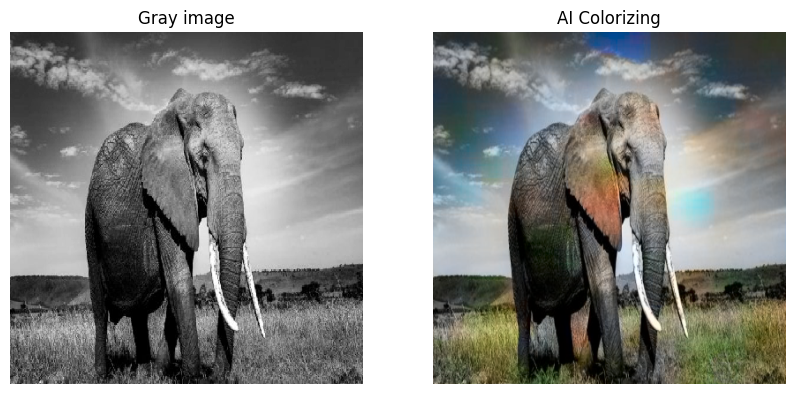

In [72]:
x = preprocess_image_to_gray_lab("test images/3.jpg")
    
x = x.reshape(1,400,400,1)

output = model.predict(x)
    
cur = mergeOutput(x,output)
    
img = lab2rgb(cur)

   
show_images("test images/3.jpg",img)
